<img src="https://pbs.twimg.com/profile_images/969600936321736704/WrwKmb8y_400x400.jpg" width="200" height="200" />

# Fitting Growth Response

### Adapted for SimFarm2030
Rather than model the sensitivities, we can model the growth curve directly. For simplicity, lets assume the the growth factor curve has a gaussian shape, with 3 parameters, a $\mu$ which determines the location of the curve, $\sigma$ which determines the width and $A$ (Normalisation) which determines the height.
$$ A\exp{(-0.5((T-\mu)/\sigma)^2)}$$

The growth curve should be the same for all countries and states. Lets fit this on the US states growing Maize.

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline

### Define states to fit over
As we are modelling the growth function with respect to temperature, we need to use the absolute temperature measurements rather than anomalies. Lets add back the climatological mean to the anomalies.

Lets read in our Stan model and compile

In [55]:
# Compile model
sm=pystan.StanModel(file='./stan/BMSM-GaussGR.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d04a20d59a41a46fcc332e2654a5244e NOW.
C:\Users\Andrew\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Andrew\AppData\Local\Temp\tmp3bd3rbsm\stanfit4anon_model_d04a20d59a41a46fcc332e2654a5244e_5782735024079537506.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


As a first attempt, lets use the yield anomalies data and add back a constant 6. We will deal with fitting the Yield trend due to efficiency later.

In [56]:
templists,rainlists,yieldlist =[],[],[]

for counter in range(1,7):
    templists.append(np.load('data/Temps'+str(counter)+'.npy'))
    
for counter in range(1,7):
    rainlists.append(np.load('data/Rain'+str(counter)+'.npy'))

for counter in range(1,7):
    yieldlist.append(np.load('data/Yield'+str(counter)+'.npy'))
    
rainlists = np.array(rainlists)
templists = np.array(templists)
yieldlist= np.array(yieldlist)

templists = templists.reshape(6,int(len(templists[0])/12),12)

templists= templists[:,:,4:10]

rainlists = rainlists.reshape(6,int(len(rainlists[0])/12),12)
rainlists= rainlists[:,:,4:10]

data={
    'n_regions':6,
    'n_years':8,
    'd_temp':templists,
    'd_precip':rainlists,
    'd_yields':yieldlist,
    'n_gf':40,
    'temp':np.arange(0,40,1),
    'precip':np.arange(0,200,5)
}
            


Lets fit the model and look at summary statistics

In [57]:
fit=sm.sampling(data=data,chains=4,iter=1000,verbose=True,seed=1308)

In [58]:
fit

Inference for Stan model: anon_model_d04a20d59a41a46fcc332e2654a5244e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                14.53    0.02   0.49  13.71  14.18  14.48  14.81  15.65    608    1.0
sigma              5.55    0.03   0.73   4.32   5.03   5.48   6.01    7.2    678    1.0
norm               2.07  1.9e-3   0.05   1.98   2.03   2.07    2.1   2.18    800    1.0
fdy[1]             0.08  2.0e-3   0.06 9.8e-3   0.04   0.06   0.11   0.22    814    1.0
fdy[2]             0.12  2.6e-3   0.07   0.02   0.06    0.1   0.16    0.3    808    1.0
fdy[3]             0.17  3.2e-3   0.09   0.04    0.1   0.15   0.22   0.39    804    1.0
fdy[4]             0.24  3.9e-3   0.11   0.07   0.16   0.23   0.31   0.49    802    1.0
fdy[5]             0.34  4.5e-3   0.13   0.13   0.25   0.33   0.43   0.61    804    1.0
fdy[6]             0.

We now use some more sophisticated diagnostics to check the inference is behaving properly

In [59]:
# carry out some diagnostic checks on fit
import stan_utility
stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [60]:
samples=fit.extract()

## Examine posterior samples
Now lets take a detailed look at the posterior samples from the fit. We will examine:
1. The posterior distribution on the growth curve parameters
2. The posterior distribution on the growth curve
3. Posterior predicitive checks (i.e. comparing predicited yield to real world yield)

Text(0, 0.5, '$dy$ [tonnes ha$^{-1}$]')

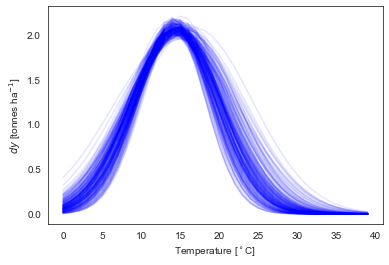

In [61]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['temp'],samples['fdy'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature [$^\circ$C]')
plt.ylabel(r'$dy$ [tonnes ha$^{-1}$]')
#plt.title('Growth Curve')1d_Gauss_temp_post_sample_growth_curve
#plt.savefig('./figs/1d_Gauss_temp_post_sample_growth_curve.pdf')
#plt.savefig('./figs/1d_Gauss_temp_post_sample_growth_curve.png')

The figure above shows growth curve samples from the posterior. Each curve is a possible growth curve. Where the lines overlap most represents the curve is known more precisely at these points, compared to where the lines are more spaced indicating there is more uncertianty. Our results indicate that the high temperature tail to the growth curve is known to a good degree of precison where as the the low temperature tail is more uncertian. (Adapted for SimFarm2030 this is the opposite)

C:\Users\Andrew\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
C:\Users\Andrew\Anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
C:\Users\Andrew\Anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: The following kwargs were not used by contour: 'normed'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


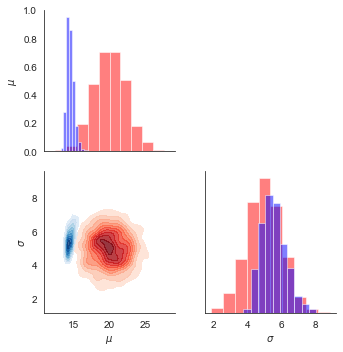

In [62]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([20,5]),
                                              np.array([[5.0,0.0],[0.0,1.0]]),2000),columns=['$\mu$','$\sigma$'])
g=sns.PairGrid(data=df,size=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
df=pd.DataFrame(np.vstack((samples['mu'],samples['sigma'])).T,columns=['$\mu$','$\sigma$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

g.axes[0,1].set_axis_off()


#plt.savefig("./figs/output.png")

The figure above shows the prior (red) and posterior (blue) distribution for our parameters of the growth function. The bottom left plot shows the 2D distribution of $\mu$ and $\sigma$, and plotted alongside are the two 1D marginalised probability distributions. It is clear that the infered posterior probability distribution has significantly shrunk compared to prior, indicating the fit is being driven by the data.

## Posterior Predictive Checks
Lets now do a couple of posterior predicitive checks. Lets first visualise the predicited yield distributions coming from the model with a violin plot and plot the real yield data on top.

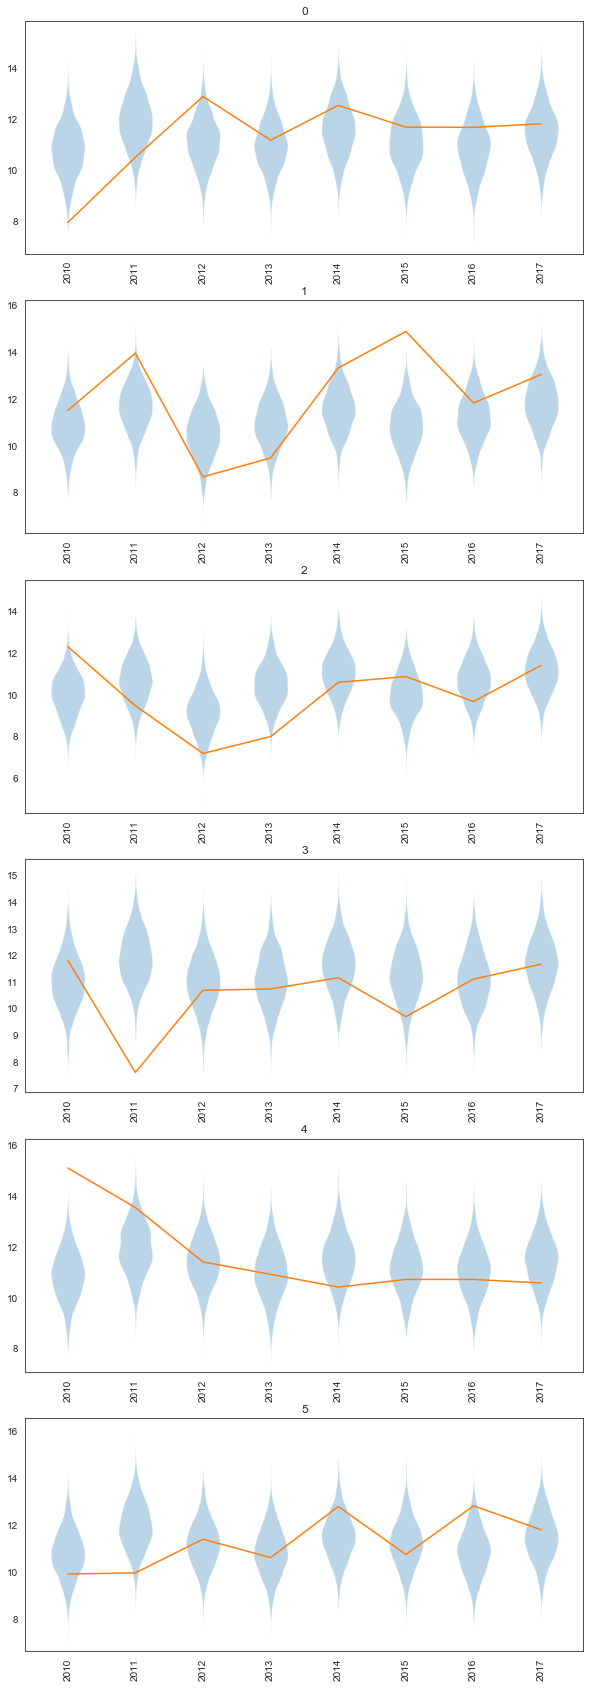

In [63]:
plt.figure(figsize=(10,5*6))
for s in range(0,6):
    plt.subplot(len(states),1,s+1)
    plt.violinplot(samples['pred_yields'][:,s,:],showextrema=False);
    plt.xticks(range(1,9),np.arange(2010,2018),rotation=90);
    plt.plot(range(1,9),fit.data['d_yields'][s,:])
    plt.title(s)

Most points lie in the distribution, indiciating a reasonable fit. Lets now quantify

### Posterior Predictive checking and Bayesian P-value maps

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, [Gelman et al. 1996](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf) is a good starting point.

For our case, the best way to carry out posterior predictive checks is to think about the yield in one year. We can look at where the real yield value is in relation to the distribution from $y^{rep}$. 

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()


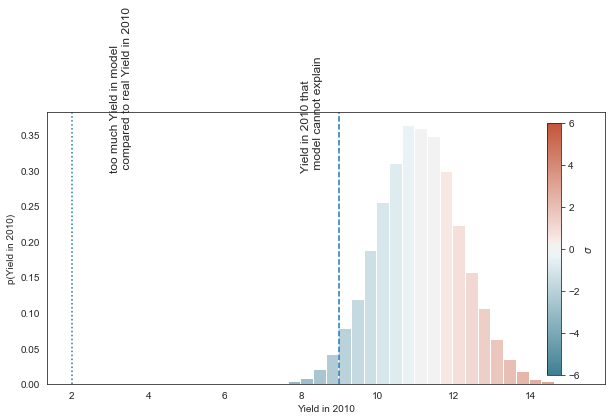

In [64]:
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(samples['pred_yields'][:,0,:], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(samples['pred_yields'][:,0,:]))/np.std(samples['pred_yields'][:,0,:]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('Yield in 2010')
plt.ylabel('p(Yield in 2010)')
plt.axvline(9, linestyle='--')
plt.axvline(2,linestyle=':')
plt.annotate('Yield in 2010 that \n model cannot explain',xy=(8, 0.01),  xycoords='data',
            xytext=(8, 0.3), textcoords='data',rotation='vertical',size='large')
plt.annotate('too much Yield in model \n compared to real Yield in 2010',xy=(3, 0.01),  xycoords='data',
            xytext=(3, 0.3), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

We can calculate fraction of $y^{rep}$ samples above and below real yield value. This is often referred to as the Bayesian p-value and is telling us the probability of drawing the real yield value, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* $\sim 0.5$ means our model is consistent with the data 
* 0.99 or 0.01 means model is missing something.

We can convert this to a typical '$\sigma$' level.

In [65]:
def Bayesian_Pval(yields,pred_yields):
    import scipy.stats as st
    Pvals=np.empty_like(yields)
    n_reg,n_years=yields.shape
    for r in range(0,n_reg):
        for y in range(0,n_years):
            ind=pred_yields[:,r,y]<yields[r,y]
            Pvals[r,y]=st.norm.ppf(ind.sum()/pred_yields[:,r,y].size)
    return Pvals

In [66]:
Pvals=Bayesian_Pval(fit.data['d_yields'],samples['pred_yields'])

Text(0, 0.5, 'P value')

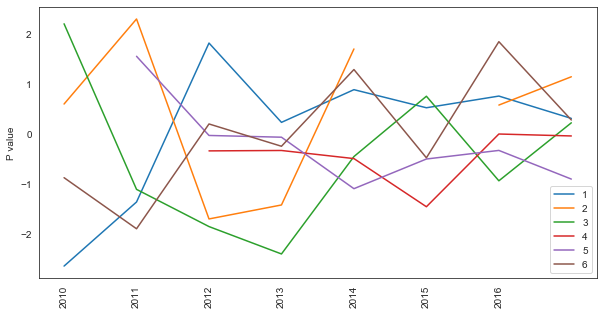

In [67]:
plt.figure(figsize=(10,5))
for s in range(0,6):
    plt.plot(Pvals[s,:],label=s+1)
plt.xticks(range(0,7),np.arange(2010,2017),rotation=90);
plt.legend()
plt.ylabel('P value')

#plt.savefig("./figs/pvalues_all.png".format(states[s]))
#plt.savefig("./figs/pvalues_all.pdf".format(states[s]))

The plot above shows the P values for every state. Most years are between -1 and 1, indicating that the yields are a good fit given the uncertianties in model. The exceptions are 1988,1991, 1993 2002 and 2012 where the yield was dramatically lower than predicited. This would suggest a failure in the model, most likely being the assumption of 

# Fit Yield trend